# Pipelining and Base Model

In [1]:
import numpy as np
import pandas as pd
import help_functions as hf

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('RTA Dataset.csv')
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [3]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    
    # here you define the operation it should perform
    def transform(self, X, y=None, **fit_params):
        return X.todense()
    
    #just return self
    def fit(self, X, y=None, **fit_params):
        return self

In [5]:
oe = OrdinalEncoder()
knn_imputer = KNNImputer()
fancy_knn = KNN()

preprocess = FunctionTransformer(hf.preprocess)
encode = FunctionTransformer(hf.encode, kw_args={'encoder': oe})
impute = FunctionTransformer(hf.impute, kw_args={'imputer': knn_imputer})
ohe = OneHotEncoder(handle_unknown='ignore')
k_best = SelectKBest(k=21)
pca = PCA(n_components=21)
base_model = LogisticRegression(multi_class='multinomial', max_iter=1000)

In [6]:
oh = make_column_transformer(
    (ohe, hf.cat_col_without_order)
)

In [7]:
main_pipe_k_best = Pipeline([
        ('preprocess', preprocess),                 
        ('encoder', encode),        
        ('impute', impute),
        ('ohe', oh),                
        ('k_best', k_best),
        ('model', base_model),
    ])

main_pipe_pca = Pipeline([
        ('preprocess', preprocess),                 
        ('encoder', encode),
        ('impute', impute),
        ('ohe', ohe),   
        ('to_dense', ToDenseTransformer()),
        ('pca', pca),
        ('model', base_model),
    ])

In [8]:
from sklearn import set_config
set_config(display='diagram')

main_pipe_k_best

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess at 0x0000026110BC4160>)),
                ('encoder',
                 FunctionTransformer(func=<function encode at 0x0000026111D8BB80>,
                                     kw_args={'encoder': OrdinalEncoder()})),
                ('impute',
                 FunctionTransformer(func=<function impute at 0x0000026111E273A0>,
                                     kw_args={'imputer': KNNImputer()})),
                ('ohe',
                 ColumnTransformer(transfor...
                                                   'Types_of_Junction',
                                                   'Type_of_vehicle',
                                                   'Vehicle_driver_relation',
                                                   'Light_conditions',
                                                   'Educational_level',
                                                   'Road_allignment',
                                                   'Cause_of_accident',
                                                   'Fitness_of_casuality',
                                                   'Road_surface_type',
                                                   'Owner_of_vehicle',
                                                   'Lanes_or_Medians',
                                                   'Area_accident_occured'])])),
                ('k_best', SelectKBest(k=21)),
                ('model',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [9]:
main_pipe_k_best.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess at 0x0000026110BC4160>)),
                ('encoder',
                 FunctionTransformer(func=<function encode at 0x0000026111D8BB80>,
                                     kw_args={'encoder': OrdinalEncoder()})),
                ('impute',
                 FunctionTransformer(func=<function impute at 0x0000026111E273A0>,
                                     kw_args={'imputer': KNNImputer()})),
                ('ohe',
                 ColumnTransformer(transfor...
                                                   'Types_of_Junction',
                                                   'Type_of_vehicle',
                                                   'Vehicle_driver_relation',
                                                   'Light_conditions',
                                                   'Educational_level',
                                                   'Road_allignment',
                                                   'Cause_of_accident',
                                                   'Fitness_of_casuality',
                                                   'Road_surface_type',
                                                   'Owner_of_vehicle',
                                                   'Lanes_or_Medians',
                                                   'Area_accident_occured'])])),
                ('k_best', SelectKBest(k=21)),
                ('model',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [10]:
y_pred_1 = main_pipe_k_best.predict(X_test)

In [11]:
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [12]:
accuracy_score(y_test, y_pred_1)

0.8457374830852503

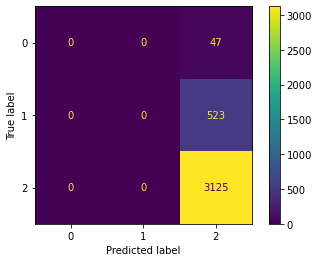

In [13]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1);

In [14]:
classification_report(y_test, y_pred_1, zero_division=1);

In [15]:
main_pipe_pca.fit(X_train, y_train)

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Pipeline(steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess at 0x0000026110BC4160>)),
                ('encoder',
                 FunctionTransformer(func=<function encode at 0x0000026111D8BB80>,
                                     kw_args={'encoder': OrdinalEncoder()})),
                ('impute',
                 FunctionTransformer(func=<function impute at 0x0000026111E273A0>,
                                     kw_args={'imputer': KNNImputer()})),
                ('ohe', OneHotEncoder(handle_unknown='ignore')),
                ('to_dense', ToDenseTransformer()),
                ('pca', PCA(n_components=21)),
                ('model',
                 LogisticRegression(max_iter=1000, multi_class='multinomial'))])

In [16]:
y_pred_2 = main_pipe_pca.predict(X_test)

C:\Users\jacky\anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [17]:
accuracy_score(y_test, y_pred_2)

0.8457374830852503

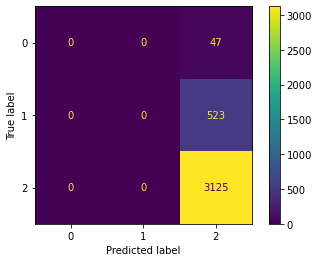

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_2);